In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

### GK-2A Dust RGB 처리를 위한 라이브러리 설치

In [2]:
#!apt-get -qq install libgeos-dev # 리눅스 설치 명령어
#!pip install netCDF4
# !pip install --upgrade -q pyproj

#!apt-get install libgeos-3.5.0
#!apt-get install libgeos-dev
#!pip install https://github.com/matplotlib/basemap/archive/master.zip
# !pip install --upgrade matplotlib
!pip install --upgrade basemap
# !pip install h5py

     |████████████████████████████████| 866 kB 7.8 MB/s eta 0:00:01
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.2
    Uninstalling numpy-1.20.2:
      Successfully uninstalled numpy-1.20.2
  Attempting uninstall: basemap
    Found existing installation: basemap 1.2.1
    Uninstalling basemap-1.2.1:
      Successfully uninstalled basemap-1.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.0 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
numba 0.54.0 requires numpy<1.21,>=1.17, but you have numpy 1.21.6 which is incompatible.


#### GK-2A 자료처리용 함수 정의
- BT2IMAGE: 입력된 BT 값을 이용하여 이미지화

In [1]:
# ==============================================================================================
# GK-2A/AMI Image
# ==============================================================================================
def BT2IMAGE(data, lon_info, opath_info, output_nm):
  from mpl_toolkits.basemap import Basemap
  import matplotlib.pyplot as plt
  #import pylab

  lon_0 = lon_info # 128.2
  m1 = Basemap(projection='geos',lon_0=lon_0,resolution=None)
  
  # 자료에서 0 이하 값에 --로 할당하여 마스크 처리
  nbar=ma.masked_where((data < 0)  ,data)

  map = Basemap(projection='geos',lon_0=lon_0,resolution='i', \
                area_thresh=10000., satellite_height=35785863.0, \
                rsphere=(6378137.0 , 6356752.3 ), \
                llcrnrx = -5499999.901174725, llcrnry = -5499999.901174725, \
                urcrnrx = 5499999.901174725, urcrnry = 5499999.901174725)

  map.drawcoastlines(linewidth=0.5)
  map.drawcountries(linewidth=0.5, color='k')
  map.drawparallels(np.arange(-90.,90.,20))
  map.drawmeridians(np.arange(-180.,180.,20))

  map.imshow(nbar, interpolation='nearest', origin='upper',cmap=plt.get_cmap('jet'), vmin=0, vmax=255) 
  cbar = m1.colorbar(size="5%", pad = 0.05)
  cbar.set_label('color range')
  plt.title(output_nm, fontsize=13, y=1.01)
  plt.axis('on')    ##  'on ' have edge line / 'off' have no edge line
  #	plt.show()      ## Show the output image before saving
  plt.savefig(opath_info+output_nm+'.png', dpi=300, bbox_inches='tight')
  plt.close('all')

  print('[Imaging Complete] :', output_nm)

파이썬 라이브러리 설정

In [1]:
import glob, os, h5py
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import *
from matplotlib.colors import ListedColormap
from PIL import Image

경로설정

In [15]:
ipath        = "/home/student/SL2023/data1/"
ipath_latlon = ipath+"input_data1/latlon/"
ipath_lsmask = ipath+"input_data1/lsmask/"

# 앞 6강의에서 산출한 output 파일 활용
ipath_l1b    = ipath+"output_01_bin/"
# 앞선 강의에서 만든 폴더
#if not os.path.exists(ipath_l1b): os.mkdir(ipath_l1b)
opath        = ipath_l1b

opath_dust_rgb = ipath+"output_02_rgb/"
#if not os.path.exists(opath_dust_rgb): os.mkdir(opath_dust_rgb)

opath_bin    = ipath+"output_02_rgb/"
#if not os.path.exists(opath_bin): os.mkdir(opath_bin)

GK2A 자료처리를 위한 고정 변수 설정

In [16]:
#-------------------------------------------------------------------------------
# 날짜 설정
date = "202103290300"
yy = date[0:4]
mm = date[4:6]
dd = date[6:8]
hh = date[8:10]
mn = date[10:12]
gk2a_date = yy+mm+dd+hh+mn
print("[GK-2A/AMI Scene Information] :", gk2a_date)

#-------------------------------------------------------------------------------
# 자료 읽기를 위한 x, y dimension 상수 설정 
xdims_020= 5500 ; ydims_020= 5500 # 2km 공간 해상도

#-------------------------------------------------------------------------------
# Red, Green, Blue Channel
red_1_name   = 'ir124'
red_2_name   = 'ir105'
green_1_name = 'ir105'
green_2_name = 'ir087'
blue_name    = 'ir105'

#-------------------------------------------------------------------------------
# RGB recipe condition (# 경험적으로 결정된 상수)
red_min       =   -2.
red_max       =    2.5
green_min     =    0.
green_max     =   18.
blue_min      =  261.
blue_max      =  289.
red_gamma     =    1.0
green_gamma   =    1.85
blue_gamma    =    1.0

#-------------------------------------------------------------------------------
# Initializing Variables
red_1_raw_data   = 0
red_2_raw_data   = 0
green_1_raw_data = 0
green_2_raw_data = 0
blue_raw_data    = 0

red_1_data       = 0.
red_2_data       = 0.
green_1_data     = 0.
green_2_data     = 0.
blue_data        = 0.

[GK-2A/AMI Scene Information] : 202103290300


자료 읽기

In [17]:
#-------------------------------------------------------------------------------
# 위도, 경도, 육상/해상 마스크
gk2a_lat_2km    = np.fromfile(ipath_latlon+'Lat_2km.bin',dtype=np.float32).reshape(5500,5500)
gk2a_lon_2km    = np.fromfile(ipath_latlon+'Lon_2km.bin',dtype=np.float32).reshape(5500,5500)
gk2a_lsmask_2km = np.fromfile(ipath_lsmask+'lsmask_2km.bin',dtype=np.int16).reshape(5500,5500)
print("[Reading complete] : GK-2A/AMI Latitude, Longitude, Land/Sea Mask")

#-------------------------------------------------------------------------------
# 채널 자료
fn_ir087 = "gk2a_ir087_202103290300.bin"
data_ir087 = np.fromfile(ipath_l1b+fn_ir087, dtype=np.float32).reshape(5500,5500)

fn_ir105 = "gk2a_ir105_202103290300.bin"
data_ir105 = np.fromfile(ipath_l1b+fn_ir105, dtype=np.float32).reshape(5500,5500)

fn_ir124 = "gk2a_ir124_202103290300.bin"
data_ir124 = np.fromfile(ipath_l1b+fn_ir124, dtype=np.float32).reshape(5500,5500)
print("[Reading complete] : GK-2A/AMI IR 8.7, 10.5, 12.4 micrometer data")

[Reading complete] : GK-2A/AMI Latitude, Longitude, Land/Sea Mask
[Reading complete] : GK-2A/AMI IR 8.7, 10.5, 12.4 micrometer data


### GK-2A DUST-RGB 계산 
#### Min. / Max. / Gamma 값 설정

In [18]:
# Calc. RED
red_data = data_ir124 - data_ir105

# Calc. GREEN
green_data = data_ir105 - data_ir087

# Calc. BLUE
blue_data = data_ir105

RED, GREEN, BLUE에 들어갈 입력값 0-255로 변환

In [19]:
#-------------------------------------------------------------------------------
# 각각의 채널 영상(밝기온도)을 0-255로 Scale로 변환  ==> 그림을 그리기 위함
red_byte_data_tmp   = (255 * ((red_data - red_min) / (red_max - red_min))**(1./red_gamma)) # red_gamma는 색의 강도 조절
green_byte_data_tmp = (255 * ((green_data - green_min) / (green_max - green_min))**(1./green_gamma)) # green_gamma는 색의 강도 조절
blue_byte_data_tmp  = (255 * ((blue_data - blue_min) / (blue_max - blue_min))**(1./blue_gamma)) # blue_gamma는 색의 강도 조절

#-------------------------------------------------------------------------------
# -999 값이 있으면 0으로 할당: 필터링
red_byte_data_tmp = np.where(gk2a_lsmask_2km == -999, 0, red_byte_data_tmp)
green_byte_data_tmp = np.where(gk2a_lsmask_2km == -999, 0, green_byte_data_tmp)
blue_byte_data_tmp = np.where(gk2a_lsmask_2km == -999, 0, blue_byte_data_tmp)

# Norm BT가 0보다 작으면 0으로 할당: Min. Check
red_byte_data_tmp = np.where(red_byte_data_tmp < 0, 0, red_byte_data_tmp)
green_byte_data_tmp = np.where(green_byte_data_tmp < 0, 0, green_byte_data_tmp)
blue_byte_data_tmp = np.where(blue_byte_data_tmp < 0, 0, blue_byte_data_tmp)

# Norm BT가 255보다 크면 255로 할당: Max. Check
red_byte_data_tmp = np.where(red_byte_data_tmp > 255, 255, red_byte_data_tmp)
green_byte_data_tmp = np.where(green_byte_data_tmp > 255, 255, green_byte_data_tmp)
blue_byte_data_tmp = np.where(blue_byte_data_tmp > 255, 255, blue_byte_data_tmp)

# 실수형을  8 bit (1byte) 정수형으로 변환
red_byte_data = red_byte_data_tmp.astype('uint8')   # 0~255 => -128 ~ +128
green_byte_data = green_byte_data_tmp.astype('uint8')
blue_byte_data = blue_byte_data_tmp.astype('uint8')

# Dust RGB 결과값 출력
f = open(opath_bin+"gk2a_ami_red_byte_fd020ge_"+gk2a_date+".bin", "w")
red_byte_data.tofile(f)  
f.close()

f = open(opath_bin+"gk2a_ami_green_byte_fd020ge_"+gk2a_date+".bin", "w")
green_byte_data.tofile(f)  
f.close()

f = open(opath_bin+"gk2a_ami_blue_byte_fd020ge_"+gk2a_date+".bin", "w")
blue_byte_data.tofile(f)  
f.close()

/home/student/anaconda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


### GK-2A Dust RGB 이미지화
#### GK-2A 각 (R, G, B) 채널 이미지화

In [20]:
# output file 출력 출력 파일명
out_nm_red = "gk2a_ami_red_byte_fd020ge_"+gk2a_date
# output file 출력 디렉토리, 출력 파일명, 입력값
BT2IMAGE(red_byte_data, 128.0, opath_dust_rgb, out_nm_red)

out_nm_green = "gk2a_ami_green_byte_fd020ge_"+gk2a_date
BT2IMAGE(green_byte_data, 128.0, opath_dust_rgb, out_nm_green)

out_nm_blue = "gk2a_ami_blue_byte_fd020ge_"+gk2a_date
BT2IMAGE(blue_byte_data, 128.0, opath_dust_rgb, out_nm_blue)

# Dust RGB 생성

[Imaging Complete] : gk2a_ami_red_byte_fd020ge_202103290300
[Imaging Complete] : gk2a_ami_green_byte_fd020ge_202103290300
[Imaging Complete] : gk2a_ami_blue_byte_fd020ge_202103290300


#### GK-2A DUST RGB 합성영상 생성

In [21]:
lon_0 = 128.2
m1 = Basemap(projection='geos',lon_0=lon_0,resolution=None)

# np.zeros 함수를 이용하여 numpy 3차원 배열 8bit 정수형 자료 선언
rgb_array=np.zeros((5500,5500,3), 'uint8')   # channel 3개 
rgb_array[:,:,0] = red_byte_data  # X dimension * Y dimension * Channels
rgb_array[:,:,1] = green_byte_data
rgb_array[:,:,2] = blue_byte_data

# 이미지 처리 라이브러리 PIL(Python Imaging Library)의 Image 클래스를 사용
# Image.fromarray(rgb_array)는 NumPy 배열을 이미지로 변환하는 함수
# 입력값은 8bit 3차원 자료
rgb_png = Image.fromarray(rgb_array)

map = Basemap(projection='geos',lon_0=lon_0,resolution='i', \
                area_thresh=10000., satellite_height=35785863.0, \
                rsphere=(6378137.0 , 6356752.3 ), \
                llcrnrx = -5499999.901174725, llcrnry = -5499999.901174725, \
                urcrnrx = 5499999.901174725, urcrnry = 5499999.901174725)

map.drawcoastlines(linewidth=0.2, color='yellow')
map.drawcountries(linewidth=0.2, color='yellow')
map.drawparallels(np.arange(-90., 91., 20), linewidth=0.4, color = 'w')
map.drawmeridians(np.arange(-180., 181., 20), linewidth=0.4,color = 'w')
map.imshow(rgb_png, interpolation='nearest', origin='upper')

savefig(opath_dust_rgb + gk2a_date+'_dust_rgb.png', dpi = 300, bbox_inches='tight')
close('all')

print("All code complete")

All code complete


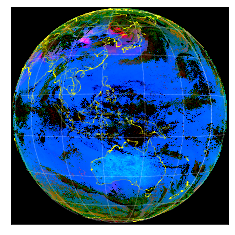

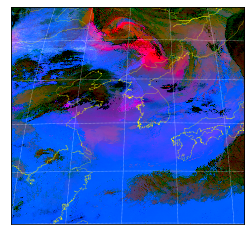

All code complete


In [22]:
lon_0 = 128.2
m1 = Basemap(projection='geos',lon_0=lon_0,resolution=None)

# np.zeros 함수를 이용하여 numpy 3차원 배열 8bit 정수형 자료 선언
rgb_array=np.zeros((5500,5500,3), 'uint8')
rgb_array[:,:,0] = red_byte_data  # X dimension * Y dimension * Channels
rgb_array[:,:,1] = green_byte_data
rgb_array[:,:,2] = blue_byte_data

# 이미지 처리 라이브러리 PIL(Python Imaging Library)의 Image 클래스를 사용
# Image.fromarray(rgb_array)는 NumPy 배열을 이미지로 변환하는 함수
# 입력값은 8bit 3차원 자료
rgb_png = Image.fromarray(rgb_array)

map = Basemap(projection='geos',lon_0=lon_0,resolution='i', \
                area_thresh=10000., satellite_height=35785863.0, \
                rsphere=(6378137.0 , 6356752.3 ), \
                llcrnrx = -5499999.901174725, llcrnry = -5499999.901174725, \
                urcrnrx = 5499999.901174725, urcrnry = 5499999.901174725)

map.drawcoastlines(linewidth=0.2, color='yellow')
map.drawcountries(linewidth=0.2, color='yellow')
map.drawparallels(np.arange(-90., 91., 20), linewidth=0.4, color = 'w')
map.drawmeridians(np.arange(-180., 181., 20), linewidth=0.4,color = 'w')
map.imshow(rgb_png, interpolation='nearest', origin='upper')

savefig(opath_dust_rgb + gk2a_date+'_dust_rgb.png', dpi = 300, bbox_inches='tight')
show()

### 한국 주변 영역 그림 ####

# 위도 및 경도 범위 설정
lat_min, lat_max = 25, 50
lon_min, lon_max = 115, 140

# 위도와 경도에 따라 해당하는 인덱스를 찾음
idx_lat = np.where((gk2a_lat_2km >= lat_min) & (gk2a_lat_2km <= lat_max))
idx_lon = np.where((gk2a_lon_2km >= lon_min) & (gk2a_lon_2km <= lon_max))

# 위도와 경도 인덱스에서 최소값과 최대값을 찾음
min_idx_lat, max_idx_lat = np.min(idx_lat[0]), np.max(idx_lat[0])
min_idx_lon, max_idx_lon = np.min(idx_lon[1]), np.max(idx_lon[1])

# 해당 영역만 이미지에서 잘라냄
rgb_array_cropped = rgb_array[min_idx_lat:max_idx_lat+1, min_idx_lon:max_idx_lon+1]

# 잘라낸 이미지를 사용하여 PIL 이미지 객체 생성
rgb_png_cropped = Image.fromarray(rgb_array_cropped)

map2 = Basemap(projection='geos',lon_0=127.5,resolution='i', \
                area_thresh=10000., satellite_height=35785863.0, \
                rsphere=(6378137.0 , 6356752.3 ), \
                llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max)

map2.drawcoastlines(linewidth=0.2, color='yellow')
map2.drawcountries(linewidth=0.2, color='yellow')
map2.drawparallels(np.arange(lat_min, lat_max, 5), linewidth=0.4, color = 'w')
map2.drawmeridians(np.arange(lon_min, lon_max, 5), linewidth=0.4,color = 'w')
map2.imshow(rgb_png_cropped, interpolation='nearest', origin='upper')

savefig(opath_dust_rgb + gk2a_date+'_dust_rgb_korea_domain.png', dpi = 300, bbox_inches='tight')
show()
print("All code complete")
